# Loading data

## Google Colab

To run the notebook You have to:

1.   Add the folder TP1 (or parent AP) to Your drive (right click > add shorcut to my drive)
2.   Mount the google drive
3.   Navigate to the folder using `%cd path/to/folder`
4.   Data is expected to be in folder `dataset/` with structure:

    *   `data.npz`
    *   `labels.csv`
    *   `pokemon_types.txt`
    
Note: If structure will be different or `dataset/` will not be in the same directory as this file (`main.ipynb`) You will have to change the paths. 

To verify You can use `!ls`, `!pwd` or You can try accessing a file on the drive (e.g. importing a function from a file). 

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Copy this cell and change path to Yours
%cd /content/drive/MyDrive/AP/TP1

!ls

/content/drive/.shortcut-targets-by-id/1PHYG04I0Rq1HPcXLG6rnTDHoHEepF_XK/AP/TP1
dataset      main.ipynb      model_transfer.png  tp1.py
logs	     model_CNN1.png  __pycache__	 tp1_sample_masks.png
logsMLP      model_MLP1.png  ReportAP1.gdoc	 tp1_sample.png
main2.ipynb  model_MLP2.png  TP1		 tp1_utils.py


In [3]:
# Copy this cell and change path to Yours
%cd /content/drive/MyDrive/AP/TP1

!ls

/content/drive/.shortcut-targets-by-id/1PHYG04I0Rq1HPcXLG6rnTDHoHEepF_XK/AP/TP1
dataset      main.ipynb      model_transfer.png  tp1.py
logs	     model_CNN1.png  __pycache__	 tp1_sample_masks.png
logsMLP      model_MLP1.png  ReportAP1.gdoc	 tp1_sample.png
main2.ipynb  model_MLP2.png  TP1		 tp1_utils.py


In [4]:
# run this to check everything is ok
from tp1_utils import load_data, images_to_pic, compare_masks, overlay_masks
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Activation, Dropout
from keras import layers, models, backend
from keras import regularizers
from keras.optimizers import Adam, Adagrad, Adadelta
import matplotlib.pyplot as plt
import numpy as np


assert callable(load_data) == True

In [5]:
ds = load_data()
for k, v in ds.items():
    print(k, v.shape)
images_to_pic("tp1_sample.png", ds["train_X"][:100])
images_to_pic("tp1_sample_masks.png", ds["train_masks"][:100])

train_X (4000, 64, 64, 3)
test_X (500, 64, 64, 3)
train_masks (4000, 64, 64, 1)
test_masks (500, 64, 64, 1)
train_classes (4000, 10)
train_labels (4000, 10)
test_classes (500, 10)
test_labels (500, 10)


**Image Visualisation**

<ipython-input-6-b4fce410bd24>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  cifar_img = plt.subplot(4, 5, i + 1)


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


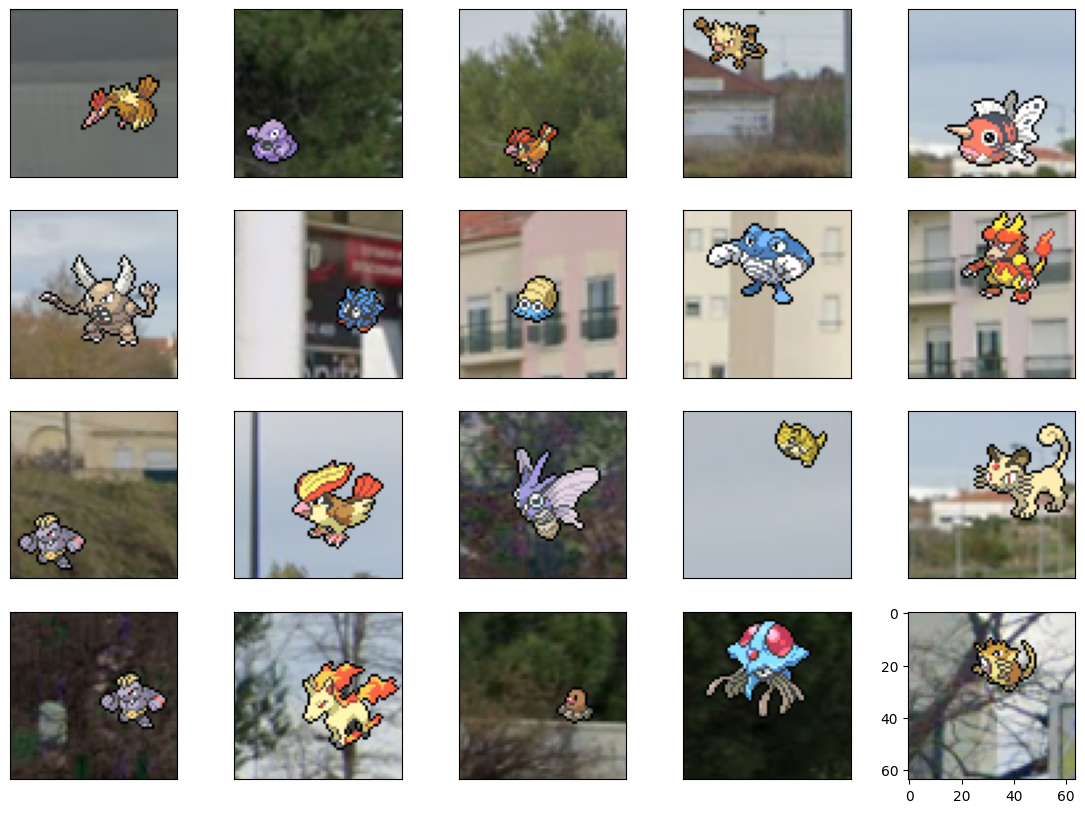

In [6]:
# Image Visualisation
import matplotlib.pyplot as plt
import numpy as np

train_X_vis = ds["train_X"]

plt.figure(figsize=(14, 10))
for i in range(20):
    rand_num = np.random.randint(0, train_X_vis.shape[0])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cifar_img = plt.subplot(4, 5, i + 1)
    plt.imshow(train_X_vis[rand_num])

print(ds["train_classes"][5])
print("\n")
print(ds["train_labels"][8])

In [7]:
def training_plot(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()


import matplotlib.pyplot as plt


def plot_history_new(history):
    """
    Plots the training and validation accuracy and loss over epochs for a given model history.

    Args:
        history (keras.callbacks.History): The history object returned by model.fit().
    """
    # Get the accuracy and loss from the history object
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    # Create the figure and two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    # Plot the accuracy on the first subplot
    ax1.plot(epochs, acc, "bo", label="Training accuracy")
    ax1.plot(epochs, val_acc, "b", label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend()

    # Plot the loss on the second subplot
    ax2.plot(epochs, loss, "bo", label="Training loss")
    ax2.plot(epochs, val_loss, "b", label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

    # Display the plot
    plt.show()

**MLP cell**

In [8]:
# MLP cell

# Validation split 3500/500 with classes(one-hot encoding)
# train_images,train_classes , train_classes, valid_classes = train_test_split( ds['train_X'], ds['train_classes'], test_size=0.125, random_state=420)
# train_images[5]
# train_classes[5]
backend.clear_session()

model_MLP = models.Sequential()
model_MLP.add(layers.Flatten(input_shape=(64, 64, 3)))

model_MLP.add(
    layers.Dense(
        32, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()
    )
)
model_MLP.add(layers.BatchNormalization())
model_MLP.add(layers.Dropout(0.21))

model_MLP.add(
    layers.Dense(
        64, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()
    )
)
model_MLP.add(layers.BatchNormalization())
model_MLP.add(layers.Dropout(0.21))

model_MLP.add(
    layers.Dense(
        64, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.07)
    )
)
model_MLP.add(layers.Dense(10))

# Caterogical crossentropy for classes
model_MLP.compile(
    optimizer=Adam(learning_rate=0.005),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# model_MLP.compile(optimizer=Adam(lr=0.06),loss='kullback_leibler_divergence',metrics=['accuracy'])
# loss='kullback_leibler_divergence'
# SparseCE for labels
# model_MLP.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.2, patience=4, verbose=1, mode="max", min_lr=0.0001
)
TensorBoard = tf.keras.callbacks.TensorBoard(
    log_dir="./logsMLP",
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=False,
)
# ,callbacks=[EarlyStop,ReduceLR,TensorBoard]
# Validation split 3500/500 with classes(one-hot encoding)
history_MLP = model_MLP.fit(
    ds["train_X"],
    ds["train_classes"],
    validation_split=0.125,
    epochs=40,
    batch_size=16,
    callbacks=[EarlyStop, ReduceLR, TensorBoard],
)
# model_MLP.summary()
# training_plot(history_MLP)

Epoch 1/40


KeyboardInterrupt: ignored

16/16 [==============================] - 0s 3ms/step - loss: 2.0106 - accuracy: 0.2800
Test accuracy: 0.2800000011920929


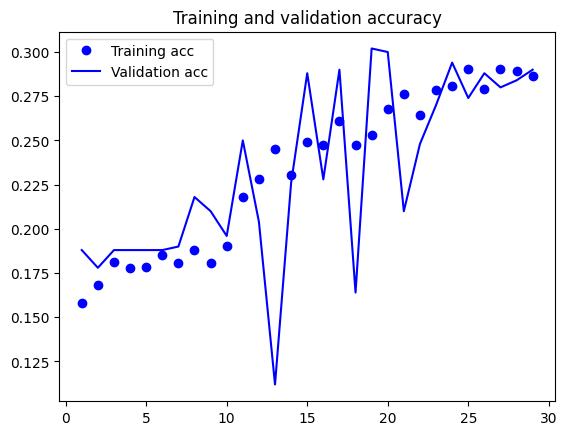

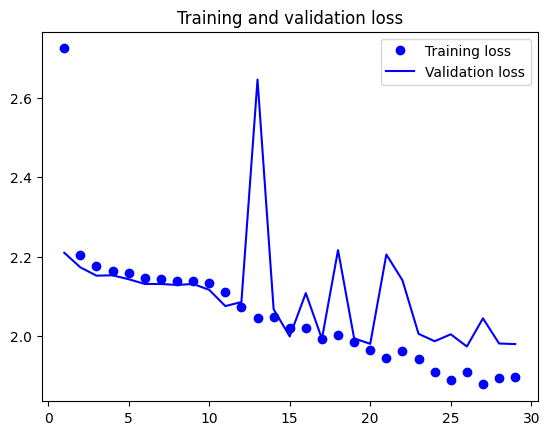

In [ ]:
loss, accuracy = model_MLP.evaluate(ds["test_X"], ds["test_classes"])
print("Test accuracy:", accuracy)

training_plot(history_MLP)
# plot_history_new(history_MLP)
# dot_img_file = './model_MLP2.png'
# tf.keras.utils.plot_model(model_MLP, to_file=dot_img_file, show_shapes=True,show_layer_activations=True)
#!pip install visualkeras
# import visualkeras
# visualkeras.layered_view(model_MLP,legend=True)

**CNN cell** 


In [9]:
# CNN cell


# Cnn Takes whole tensor 64x64x3 //  MLP -> Flatten() to vector
model_CNN = models.Sequential()
# model_CNN.add(layers.Normalization(input_shape=(64, 64, 3)))

model_CNN.add(
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
        input_shape=(64, 64, 3),
    )
)
model_CNN.add(layers.MaxPooling2D(pool_size=(3, 3), padding="same"))
model_CNN.add(layers.BatchNormalization())


model_CNN.add(
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
        kernel_regularizer=tf.keras.regularizers.L2(0.01),
    )
)
model_CNN.add(layers.MaxPooling2D(pool_size=(3, 3), padding="same"))
model_CNN.add(layers.BatchNormalization())


model_CNN.add(
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )
)
model_CNN.add(layers.MaxPooling2D(pool_size=(3, 3), padding="same"))
model_CNN.add(layers.BatchNormalization())

In [10]:
model_CNN.add(layers.Flatten())
model_CNN.add(
    layers.Dense(
        64, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01)
    )
)
model_CNN.add(layers.BatchNormalization())
model_CNN.add(layers.Dropout(0.15))

model_CNN.add(
    layers.Dense(
        32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01)
    )
)
model_CNN.add(layers.BatchNormalization())
model_CNN.add(layers.Dropout(0.15))
model_CNN.add(layers.Dense(10))

Epoch 1/25
219/219 [==============================] - 32s 141ms/step - loss: 3.5099 - accuracy: 0.2297 - val_loss: 2.9296 - val_accuracy: 0.1580 - lr: 0.0050
Epoch 2/25
219/219 [==============================] - 31s 143ms/step - loss: 2.0970 - accuracy: 0.3914 - val_loss: 3.2404 - val_accuracy: 0.1260 - lr: 0.0050
Epoch 3/25
219/219 [==============================] - 30s 137ms/step - loss: 1.8321 - accuracy: 0.4717 - val_loss: 1.9765 - val_accuracy: 0.4560 - lr: 0.0050
Epoch 4/25
219/219 [==============================] - 31s 139ms/step - loss: 1.7180 - accuracy: 0.5380 - val_loss: 2.2285 - val_accuracy: 0.4140 - lr: 0.0050
Epoch 5/25
219/219 [==============================] - 30s 138ms/step - loss: 1.6480 - accuracy: 0.6000 - val_loss: 2.6355 - val_accuracy: 0.3440 - lr: 0.0050
Epoch 6/25
219/219 [==============================] - 30s 139ms/step - loss: 1.5105 - accuracy: 0.6746 - val_loss: 1.6807 - val_accuracy: 0.5980 - lr: 0.0050
Epoch 7/25
219/219 [==============================] 

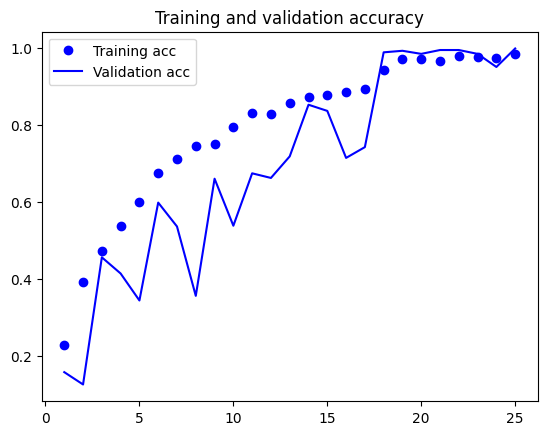

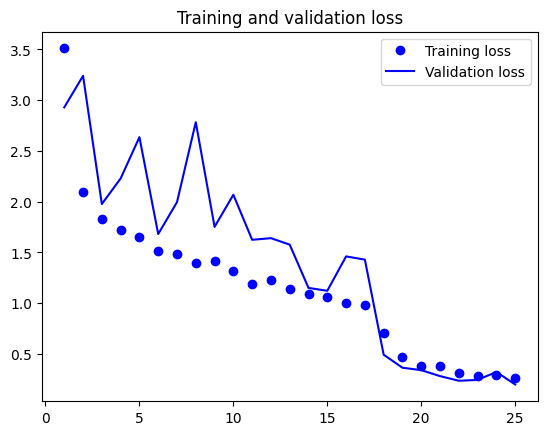

In [11]:
# To można dla resnetu dwa rozne LR ->
# optimizer1 = tf.keras.optimizers.Adam(learning_rate={'conv_layers': 0.001, 'dense_layers': 0.01})
# model_CNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_CNN.compile(
    optimizer=Adam(learning_rate=0.005),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

EarlyStop_CNN = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=7, verbose=1, mode="max", restore_best_weights=True
)
ReduceLR_CNN = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.2, patience=3, verbose=1, mode="max", min_lr=0.0001
)

history_cnn = model_CNN.fit(
    ds["train_X"],
    ds["train_classes"],
    validation_split=0.125,
    epochs=25,
    batch_size=16,
    callbacks=[EarlyStop_CNN, ReduceLR_CNN],
)

# plt.plot(history_cnn.history['accuracy'], label='accuracy')
# plt.plot(history_cnn.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

# plt.legend(loc='lower right')

# test_loss, test_acc = model_CNN.evaluate(ds['train_X'], ds['train_classes'], verbose=2)

training_plot(history_cnn)

1/1 [==============================] - 0s 154ms/step


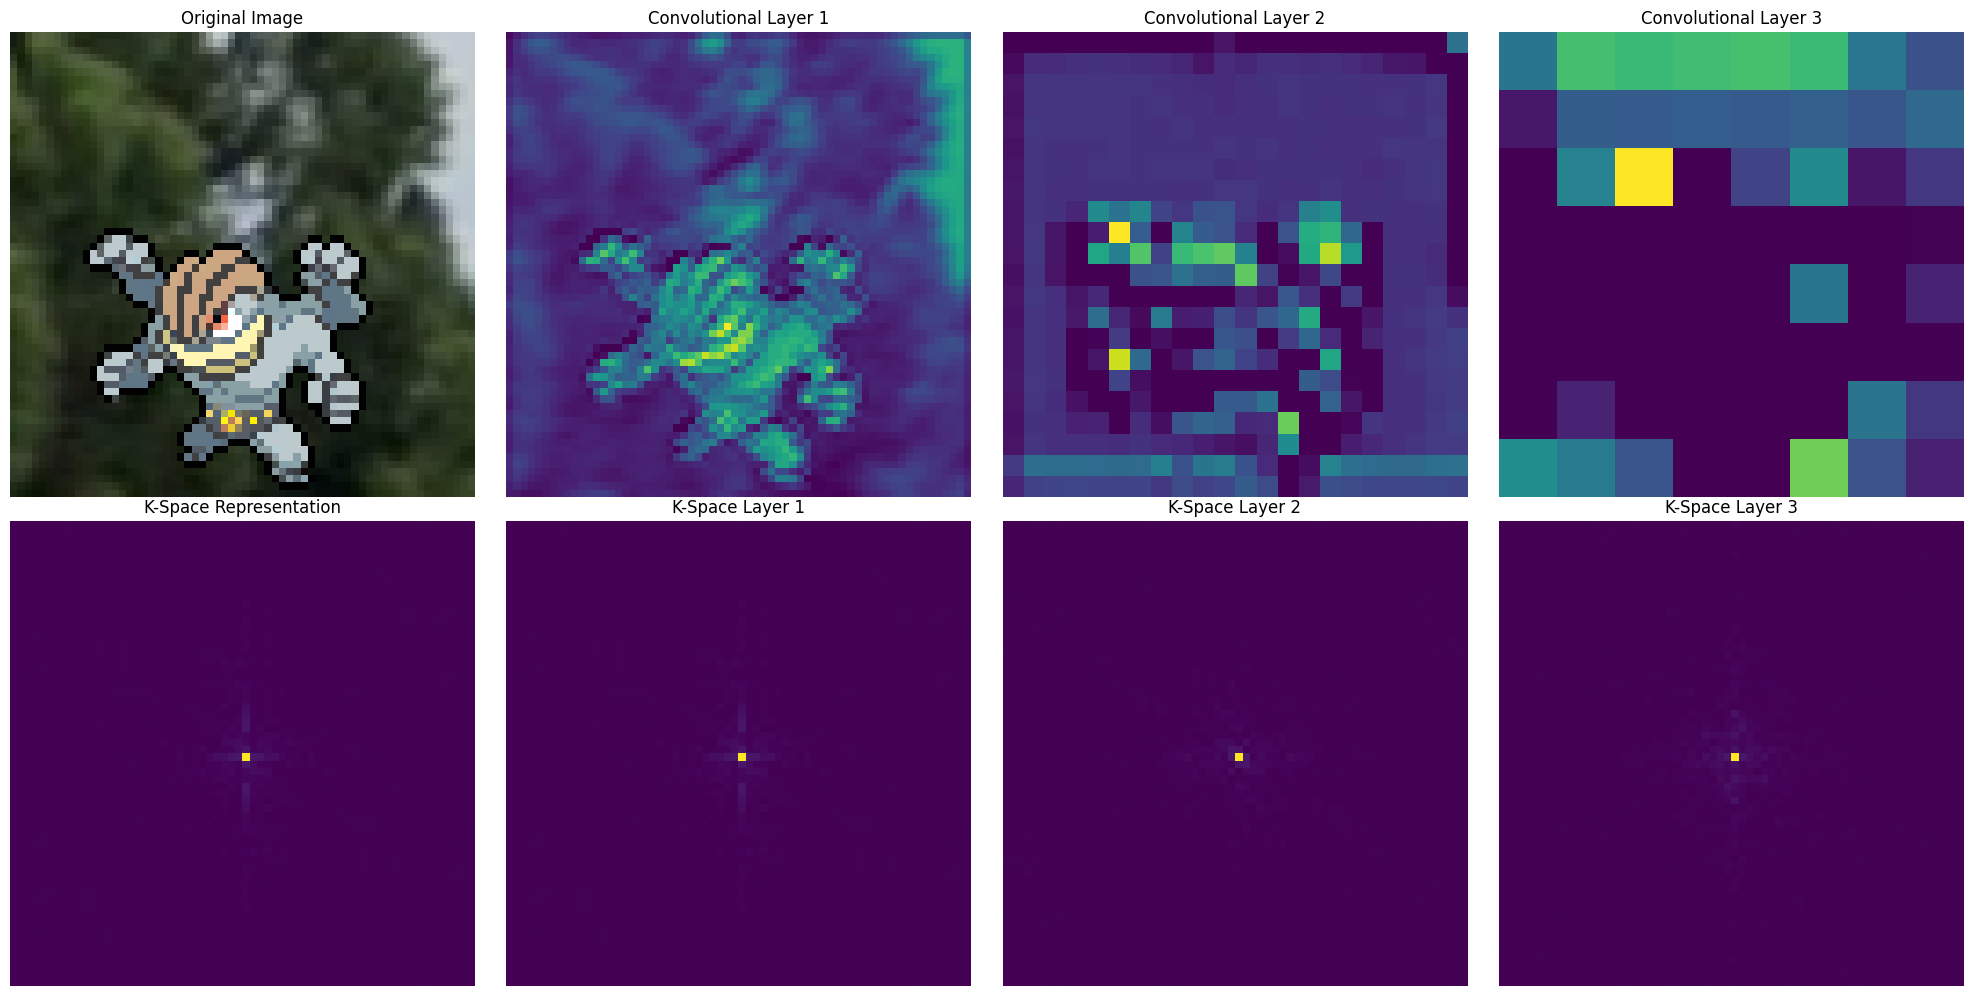

In [124]:
#Chat gpt + me effort to visualise activations 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf



def visualize_all_activations_channels(model, images, visualize_channels=True):
    # Choose a random image from the provided images
    img = images[np.random.randint(images.shape[0]), :, :, :]
    
    # Get the activations of all convolutional layers
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)
    activations = activation_model.predict(np.expand_dims(img, axis=0))

    # Plot the original image and activations for each convolutional layer
    num_activations = len(activations)
    if visualize_channels:
        fig, axs = plt.subplots(nrows=num_activations, ncols=1)
        fig.set_size_inches(6, 6 * num_activations)
        
        for i, activation in enumerate(activations):
            num_channels = activation.shape[-1]
            activation_grid = np.transpose(activation[0], (2, 0, 1)).reshape((num_channels, -1))
            axs[i].imshow(activation_grid, cmap='viridis')
            axs[i].axis('off')
            axs[i].set_title(f'Convolutional Layer {i+1} - Channels')
    else:
        fig, axs = plt.subplots(nrows=1, ncols=num_activations+1)
        fig.set_size_inches(20, 5)

        axs[0].imshow(img)
        axs[0].axis('off')
        axs[0].set_title('Original Image')

        for i, activation in enumerate(activations):
            axs[i+1].imshow(activation[0, :, :, 0], cmap='viridis')
            axs[i+1].axis('off')
            axs[i+1].set_title(f'Convolutional Layer {i+1}')
        
    plt.show()

def visualize_all_activations_channels_grid(model, images, grid_size):
    # Choose a random image from the provided images
    img = images[np.random.randint(images.shape[0]), :, :, :]
    
    # Get the activations of the last convolutional layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            last_conv_layer = layer
            break
    
    if last_conv_layer is None:
        raise ValueError('No convolutional layer found in the model.')
    
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=last_conv_layer.output)
    activations = activation_model.predict(np.expand_dims(img, axis=0))
    
    # Determine the number of channels and calculate grid dimensions
    num_channels = activations.shape[-1]
    num_rows = int(np.ceil(num_channels / grid_size))
    num_cols = min(num_channels, grid_size)
    
    # Plot the original image and channels of the last convolutional layer in a grid
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols+1)
    fig.set_size_inches((num_cols+1) * 5, num_rows * 5)
    
    axs[0, 0].imshow(img)
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Original Image')

    for i in range(num_channels):
        row = i // num_cols
        col = i % num_cols
        axs[row, col+1].imshow(activations[0, :, :, i], cmap='viridis')
        axs[row, col+1].axis('off')
        axs[row, col+1].set_title(f'Channel {i+1}')
    
    plt.tight_layout()
    plt.show()

def visualize_all_activations_fourier(model, images):
    # Choose a random image from the provided images
    img = images[np.random.randint(images.shape[0]), :, :, :]

    # Get the activations of all convolutional layers
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)
    activations = activation_model.predict(np.expand_dims(img, axis=0))

    # Compute the K-space representation for all images
    k_space = np.fft.fftshift(np.fft.fft2(np.mean(images, axis=3)))

    # Plot the original image, activations, and K-space representation
    fig, axs = plt.subplots(nrows=2, ncols=len(activations) + 1)
    fig.set_size_inches(20, 10)

    axs[0, 0].imshow(img)
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Original Image')

    axs[1, 0].imshow(np.abs(k_space[0]), cmap='viridis')
    axs[1, 0].axis('off')
    axs[1, 0].set_title('K-Space Representation')

    for i, activation in enumerate(activations):
        axs[0, i + 1].imshow(activation[0, :, :, 0], cmap='viridis')
        axs[0, i + 1].axis('off')
        axs[0, i + 1].set_title(f'Convolutional Layer {i + 1}')

        axs[1, i + 1].imshow(np.abs(k_space[i]), cmap='viridis')
        axs[1, i + 1].axis('off')
        axs[1, i + 1].set_title(f'K-Space Layer {i + 1}')

    plt.tight_layout()
    plt.show()





def visualize_all_activations(model, images):
    # Choose a random image from the provided images
    img = images[np.random.randint(images.shape[0]), :, :, :]
    
    # Get the activations of all convolutional layers
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)
    activations = activation_model.predict(np.expand_dims(img, axis=0))

    # Plot the original image and activations for each convolutional layer
    fig, axs = plt.subplots(nrows=1, ncols=len(activations)+1)
    fig.set_size_inches(20, 5)
    
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    
    for i, activation in enumerate(activations):
        axs[i+1].imshow(activation[0, :, :, 0], cmap='viridis')
        axs[i+1].axis('off')
        axs[i+1].set_title(f'Convolutional Layer {i+1}')
        
    plt.show()


#visualize_all_activations_channels(model_CNN,ds["test_X"],6)
visualize_all_activations_fourier(model_CNN,ds["test_X"])

16/16 [==============================] - 1s 49ms/step - loss: 0.2010 - accuracy: 0.9960
Test accuracy: 0.9959999918937683
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


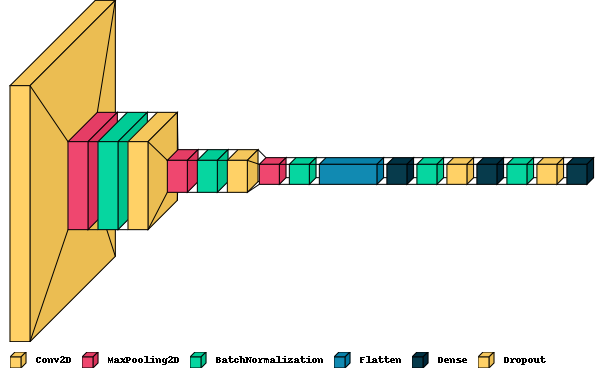

In [ ]:
loss, accuracy = model_CNN.evaluate(ds["test_X"], ds["test_classes"])
print("Test accuracy:", accuracy)

dot_img_file = "./model_CNN1.png"
tf.keras.utils.plot_model(
    model_CNN, to_file=dot_img_file, show_shapes=True, show_layer_activations=True
)
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model_CNN, legend=True)

16/16 [==============================] - 1s 55ms/step


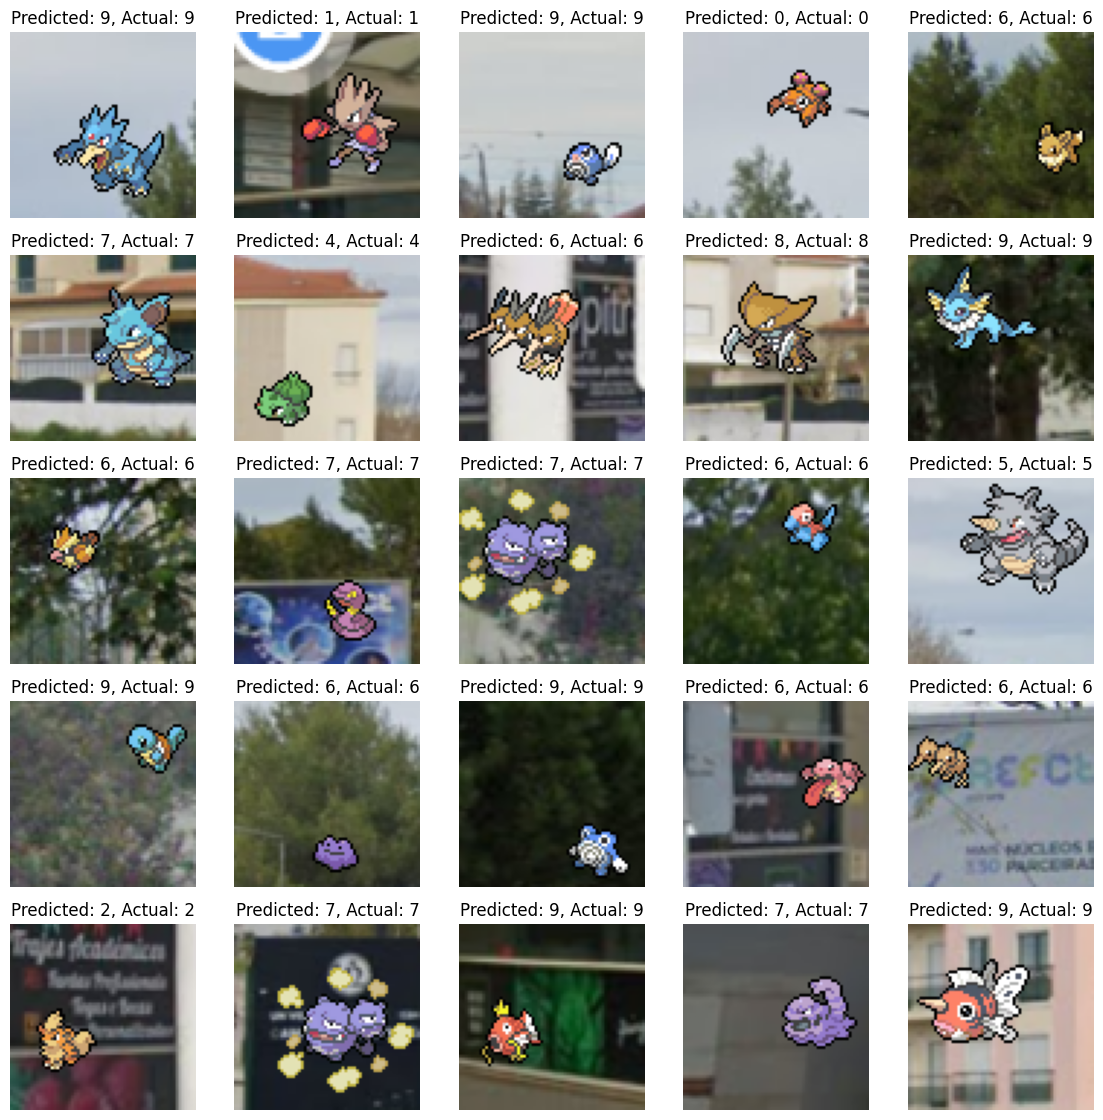

In [ ]:
# Chat gpt func
import numpy as np
import matplotlib.pyplot as plt


def plot_predictions(model, X_test, y_test):
    # Get model predictions for test images
    y_pred = model.predict(X_test)

    # Convert one-hot encoded labels to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Create a 5x5 grid of random test images and their predicted and true labels
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 14))
    for i, ax in enumerate(axes.flat):
        # Generate a random index for a test image
        idx = np.random.randint(len(X_test))

        # Display the test image and its predicted and true labels
        ax.imshow(X_test[idx])
        ax.set_title(f"Predicted: {y_pred_classes[idx]}, Actual: {y_test_classes[idx]}")
        ax.axis("off")

    plt.show()


plot_predictions(model_CNN, ds["test_X"], ds["test_classes"])

In [ ]:
# 3 Multilabel classificaition loss='binary crossentropy'
# Output layer activation 'sigmoid'
# Y = labels
#
model_3 = models.Sequential()
# model_3.add(layers.Normalization(input_shape=(64, 64, 3)))

model_3.add(
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
        input_shape=(64, 64, 3),
    )
)
model_3.add(layers.MaxPooling2D(pool_size=(3, 3), padding="same"))
model_3.add(layers.BatchNormalization())
# model_3.add(layers.Dropout(0.2))


model_3.add(
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
        kernel_regularizer=tf.keras.regularizers.L2(0.009),
    )
)
model_3.add(layers.MaxPooling2D(pool_size=(3, 3), padding="same"))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dropout(0.2))


model_3.add(
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )
)
model_3.add(layers.MaxPooling2D(pool_size=(3, 3), padding="same"))
model_3.add(layers.BatchNormalization())

In [ ]:
model_3.add(layers.Flatten())
model_3.add(
    layers.Dense(
        64, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.008)
    )
)
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dropout(0.2))

model_3.add(
    layers.Dense(
        32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.007)
    )
)
model_3.add(layers.BatchNormalization())
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(10, activation="sigmoid"))

Epoch 1/25
219/219 [==============================] - 34s 147ms/step - loss: 1.1102 - accuracy: 0.1771 - val_loss: 0.5358 - val_accuracy: 0.0840 - lr: 0.0030
Epoch 2/25
219/219 [==============================] - 32s 147ms/step - loss: 0.4419 - accuracy: 0.2409 - val_loss: 0.4910 - val_accuracy: 0.0840 - lr: 0.0030
Epoch 3/25
219/219 [==============================] - 34s 157ms/step - loss: 0.4175 - accuracy: 0.2694 - val_loss: 0.5881 - val_accuracy: 0.1340 - lr: 0.0030
Epoch 4/25
219/219 [==============================] - 31s 143ms/step - loss: 0.3989 - accuracy: 0.3309 - val_loss: 0.4701 - val_accuracy: 0.2240 - lr: 0.0030
Epoch 5/25
219/219 [==============================] - 31s 142ms/step - loss: 0.3890 - accuracy: 0.3620 - val_loss: 0.4295 - val_accuracy: 0.2280 - lr: 0.0030
Epoch 6/25
219/219 [==============================] - 31s 144ms/step - loss: 0.3745 - accuracy: 0.3906 - val_loss: 0.4230 - val_accuracy: 0.3540 - lr: 0.0030
Epoch 7/25
219/219 [==============================] 

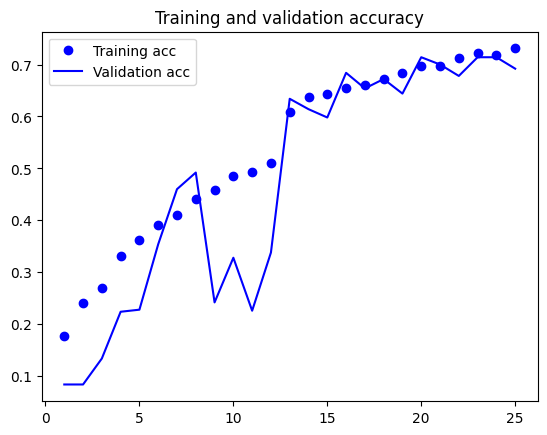

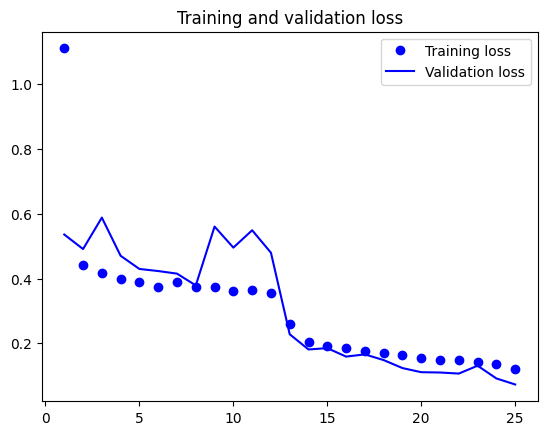

In [ ]:
model_3.compile(
    optimizer=Adam(learning_rate=0.003),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.2, patience=4, verbose=1, mode="max", min_lr=0.0001
)

history_3 = model_3.fit(
    ds["train_X"],
    ds["train_labels"],
    validation_split=0.125,
    epochs=25,
    batch_size=16,
    callbacks=[EarlyStop, ReduceLR],
)
training_plot(history_3)